In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# set random seed
np.random.seed(123)
tf.set_random_seed(123)

# import the training data 
X_total = pd.read_csv('X_musical_features.csv').drop('track_id', axis=1)

# import single genres y values
y_single_total = pd.read_csv('y_genres_onehot_single.csv').drop('Unnamed: 0', axis=1)

# import non-one-hotted y values
y_cold_single_total = pd.read_csv('y_genres_single.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_single_total, test_size=0.3, shuffle=False, stratify = None
)

# also split y cold 70/30
y_cold_train = y_cold_single_total.head(44559)
y_cold_test = y_cold_single_total.tail(y_cold_single_total.shape[0] - 44559)

# then do this for 
# *_train together
# *_test together
def unison_shuffled_copies(a, b, c):
    assert len(a) == b.shape[0]
    assert a.shape[0] == c.shape[0]
    
    p = np.random.permutation(len(a))
    return a.iloc[p, :], b.iloc[p, :], c.iloc[p, :]

#new variables with shuffled 
X_train_shuf, y_train_shuf, y_cold_train_shuf = unison_shuffled_copies(X_train, y_train, y_cold_train)

#also do this for test set

Testing for correctness in shuffling

In [4]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_shuf)
X_test_scaled = scaler.transform(X_test)

In [5]:
# del X_train, X_test

In [19]:
def create_model(learn_rate, momentum):
    model = keras.models.Sequential()
    sgd_optimizer = keras.optimizers.SGD(lr=learn_rate, decay=1e-7, momentum=momentum)

    # INPUT LAYER
    model.add(
        keras.layers.Dense(
            units=518,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='relu',
        )
    )

    # HIDDEN LAYER 1
#     model.add(
#         keras.layers.Dense(
#             units=474,
#             input_dim=518,
#             kernel_initializer='glorot_uniform',
#             bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
#             activation='relu'
#         )
#     )

    # HIDDEN LAYER 2
    model.add(
        keras.layers.Dense(
            units=300,
            input_dim=518,
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='relu'
        )
    )

    # HIDDEN LAYER 3
    model.add(
        keras.layers.Dense(
            units=200,
            input_dim=300,
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='relu'
        )
    )

    # OUTPUT LAYER
    model.add(
        keras.layers.Dense(
            units=y_train.shape[1],
            input_dim=200,
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='softmax'
        )
    )

    model.compile(
        optimizer=sgd_optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

## Best Things So Far
* Batch Size: **60** _(maybe 64 to optimize because of powers of 2)_
* Optimizer: **SGD**

In [20]:
model = KerasClassifier(
    build_fn=create_model,
    batch_size=64,
    epochs=10,
    verbose=0)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    n_jobs=1,
    verbose=2,
)
grid_result = grid.fit(X_test_scaled, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] learn_rate=0.001, momentum=0.0 ..................................
[CV] ................... learn_rate=0.001, momentum=0.0, total=  15.7s
[CV] learn_rate=0.001, momentum=0.0 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s


[CV] ................... learn_rate=0.001, momentum=0.0, total=  15.8s
[CV] learn_rate=0.001, momentum=0.0 ..................................
[CV] ................... learn_rate=0.001, momentum=0.0, total=  16.7s
[CV] learn_rate=0.001, momentum=0.2 ..................................
[CV] ................... learn_rate=0.001, momentum=0.2, total=  16.6s
[CV] learn_rate=0.001, momentum=0.2 ..................................
[CV] ................... learn_rate=0.001, momentum=0.2, total=  16.0s
[CV] learn_rate=0.001, momentum=0.2 ..................................
[CV] ................... learn_rate=0.001, momentum=0.2, total=  16.1s
[CV] learn_rate=0.001, momentum=0.4 ..................................
[CV] ................... learn_rate=0.001, momentum=0.4, total=  16.4s
[CV] learn_rate=0.001, momentum=0.4 ..................................
[CV] ................... learn_rate=0.001, momentum=0.4, total=  16.3s
[CV] learn_rate=0.001, momentum=0.4 ..................................
[CV] .

[CV] ..................... learn_rate=0.2, momentum=0.2, total=  22.2s
[CV] learn_rate=0.2, momentum=0.4 ....................................
[CV] ..................... learn_rate=0.2, momentum=0.4, total=  22.2s
[CV] learn_rate=0.2, momentum=0.4 ....................................
[CV] ..................... learn_rate=0.2, momentum=0.4, total=  22.6s
[CV] learn_rate=0.2, momentum=0.4 ....................................
[CV] ..................... learn_rate=0.2, momentum=0.4, total=  22.7s
[CV] learn_rate=0.2, momentum=0.6 ....................................
[CV] ..................... learn_rate=0.2, momentum=0.6, total=  22.6s
[CV] learn_rate=0.2, momentum=0.6 ....................................
[CV] ..................... learn_rate=0.2, momentum=0.6, total=  22.8s
[CV] learn_rate=0.2, momentum=0.6 ....................................
[CV] ..................... learn_rate=0.2, momentum=0.6, total=  23.5s
[CV] learn_rate=0.2, momentum=0.8 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 32.9min finished


In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.260303 using {'optimizer': 'SGD'}
0.260303 (0.032376) with: {'optimizer': 'SGD'}
0.211028 (0.009815) with: {'optimizer': 'RMSprop'}
0.237053 (0.012307) with: {'optimizer': 'Adagrad'}
0.209666 (0.021126) with: {'optimizer': 'Adadelta'}
0.229094 (0.022945) with: {'optimizer': 'Adam'}
0.214013 (0.005979) with: {'optimizer': 'Adamax'}
0.212965 (0.017355) with: {'optimizer': 'Nadam'}


In [ ]:
# history = model.fit(
# X_train_scaled, y_train_shuf,
# batch_size=100, epochs=7,
# verbose=1,
# validation_data=(X_test_scaled, y_test),
# )

# plt.plot(history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['gn', 'gu', 'ln', 'lu', 'hn', 'hu'], loc='upper left')
# plt.show()

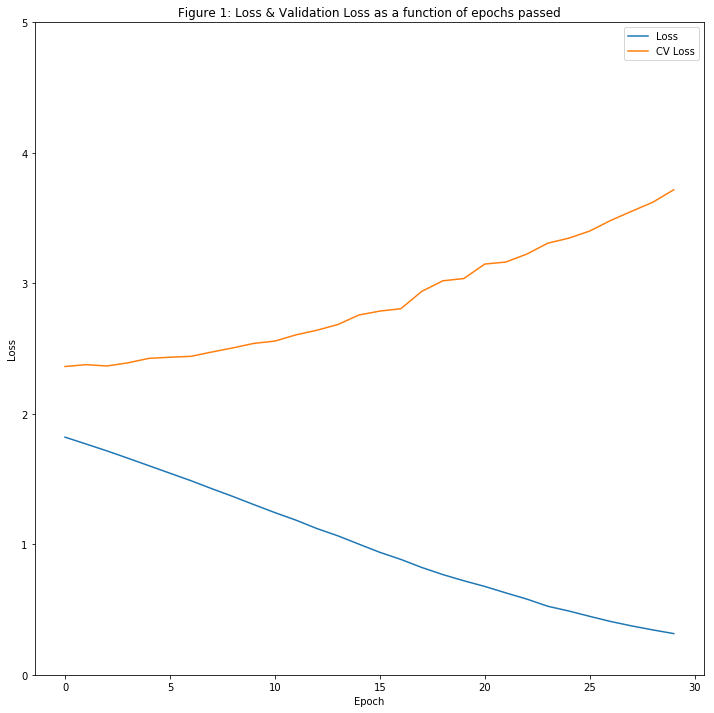

In [55]:
# loss, val_loss = history.history.values()

# plt.plot(loss, label="Loss")
# plt.plot(val_loss, label="CV Loss")
# plt.legend()
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.ylim(bottom=0, top=5)
# plt.title('Figure 1: Loss & Validation Loss as a function of epochs passed')
# plt.rcParams["figure.figsize"] = [12,12]
# plt.show()

In [56]:
# y_train_pred = model.predict_classes(X_train_scaled, verbose=0)
# y_test_pred = model.predict_classes(X_test_scaled, verbose=0)

# train_acc = np.sum(y_cold_train_shuf.values.flatten() == y_train_pred, axis=0) / 44559
# test_acc = np.sum(y_cold_test.values.flatten() == y_test_pred, axis=0) / 19097

# print(f"Accuracy on training set: {train_acc}")
# print(f"Accuracy on test set: {test_acc}")

Accuracy on training set: 0.8906842613164568
Accuracy on test set: 0.21170864533696393
